# VAE Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import keras
import Image_finder
import os
import cv2
import sklearn
from matplotlib import pyplot as plt
import shutil

proj_loc = os.path.join(os.getcwd(),"faces_resized\\")

Using TensorFlow backend.


The repository of face images have been sourced from my iphone photos library, using cv2 face id algorithim to idenitfy faces and crop them out. In total there are 855 200x200x3 face images.

---------- Imagefinder ----------
No. directories: 1
No. files: 855


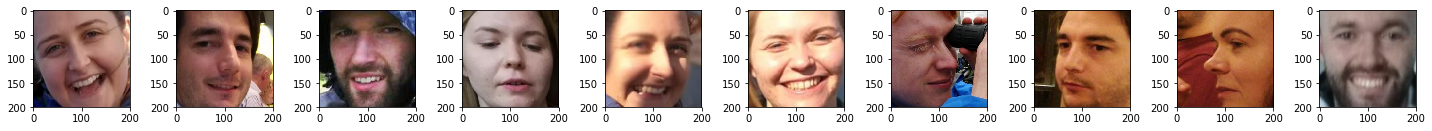

In [2]:
a = Image_finder.Image_finder(directory=proj_loc)
img_list = np.array([cv2.imread(file).astype('uint8') for file in a.file_lst()])
img_list = np.clip(img_list[:,:,:,::-1]/255.0,0.0,1.0).astype('float32')

# Plot some of the images to see what's they look like
n=10
fig, axes = plt.subplots(1,n,figsize=(2*n,5))

counter = 0
for i in range(n):
    axes[i].imshow(img_list[counter])
    counter+=1

fig.tight_layout()
plt.show()

Writing a function to generate batches of data to allow for more robust training, before defining my graph and running the code.

In [3]:
def mini_batches(data,batch_size,shuffle=False):
    
    assert type(data) is np.ndarray
    assert 0<batch_size<=data.shape[0]
    
    if shuffle:
        data = sklearn.utils.shuffle(data)
        # wierd issue where using numpy.random.shuffle causes all arrays to be shuffled
        #np.random.shuffle(data)
        
    for i in range(0,data.shape[0],batch_size):
        batch = data[i:i+batch_size]
        yield batch
        

In [4]:
def delete_files(folder): 
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [5]:
def img_con(img):
    return (img*255).astype('uint8')[:,:,::-1]

In [6]:
def conv2d(x, W, b, strides=1, activation=tf.nn.relu):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    #x = tf.nn.bias_add(x, b)
    #return activation(x)
    return x

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

def upsample(x, k = [200,200]):
    return tf.image.resize_images(x,size=k)

def batch_norm(x):
    return tf.layers.batch_normalization(x)

In [7]:
def gen_enc_weights():
    with tf.variable_scope("enc_weights", reuse=tf.AUTO_REUSE):
        weights_enc = {
            'conv1': tf.get_variable('CONV1', shape=(3,3,3,6), initializer=tf.contrib.layers.xavier_initializer()), 
            'conv2': tf.get_variable('CONV2', shape=(3,3,6,6), initializer=tf.contrib.layers.xavier_initializer()), 
            'conv3': tf.get_variable('CONV3', shape=(3,3,6,6), initializer=tf.contrib.layers.xavier_initializer()),
            'mean': tf.get_variable('MEAN', shape=(60000,2), initializer=tf.contrib.layers.xavier_initializer()), 
            'sigma': tf.get_variable('SIGMA', shape=(60000,2), initializer=tf.contrib.layers.xavier_initializer()) 
        }
        biases_enc = {
            'conv1': tf.get_variable('CONV1_B', shape=(3), initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable('CONV2_B', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
            'conv3': tf.get_variable('CONV3_B', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
            'mean': tf.get_variable('MEAN_B', shape=(2), initializer=tf.contrib.layers.xavier_initializer()),
            'sigma': tf.get_variable('SIGMA_B', shape=(2), initializer=tf.contrib.layers.xavier_initializer())
        }

        enc_wb = [weights_enc,biases_enc]
    
    return enc_wb

In [8]:
def gen_dec_weights():
    with tf.variable_scope("dec_weights", reuse=tf.AUTO_REUSE):
        weights_dec = {
            'latent_to_img':tf.get_variable('LTI', shape=(2,60000), initializer=tf.contrib.layers.xavier_initializer()),
            'conv1': tf.get_variable('DEC_CONV1', shape=(3,3,6,6), initializer=tf.contrib.layers.xavier_initializer()), 
            'conv2': tf.get_variable('DEC_CONV2', shape=(3,3,6,6), initializer=tf.contrib.layers.xavier_initializer()), 
            'conv3': tf.get_variable('DEC_CONV3', shape=(3,3,6,3), initializer=tf.contrib.layers.xavier_initializer()) 
        }
        biases_dec = {
            'latent_to_img':tf.get_variable('LTI_B', shape=(60000), initializer=tf.contrib.layers.xavier_initializer()),
            'conv1': tf.get_variable('DEC_CONV1_B', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
            'conv2': tf.get_variable('DEC_CONV2_B', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
            'conv3': tf.get_variable('DEC_CONV3_B', shape=(3), initializer=tf.contrib.layers.xavier_initializer())
        }

        dec_wb = [weights_dec,biases_dec]
    
    return dec_wb

In [9]:
def encoder(x, weights=gen_enc_weights(), activation=tf.nn.leaky_relu):

    #200x200x3
    x = conv2d(x,weights[0]['conv1'],weights[1]['conv1'],activation=activation)
    x = tf.layers.batch_normalization(x)

    x = conv2d(x,weights[0]['conv2'],weights[1]['conv2'],activation=activation)
    x = tf.layers.batch_normalization(x)
    
    #100x100x3
    x = maxpool2d(x, k=2)
    x = tf.layers.batch_normalization(x)
    
    #100x100x3
    x = conv2d(x,weights[0]['conv3'],weights[1]['conv3'],activation=activation)
    x = tf.layers.batch_normalization(x)
    
    #Flatten the tensor
    x = tf.reshape(x,[-1,60000])
    
    # Reducing down to latent representation
    x_mean = tf.add(tf.matmul(x, weights[0]['mean']), weights[1]['mean'])
    x_log_sigma = tf.add(tf.matmul(x, weights[0]['sigma']), weights[1]['sigma'])
    
    return x_mean, x_log_sigma


def decoder(x, weights=gen_dec_weights(), activation=tf.nn.leaky_relu):
    
    # Take input vector from latent represenation and reshape back into
    # 50x50x3 image
    x = tf.add(tf.matmul(x, weights[0]['latent_to_img']), weights[1]['latent_to_img'])
    x = tf.reshape(x,shape=tf.convert_to_tensor([-1, 100, 100, 6]))
    
    #100x100x3
    x = conv2d(x,weights[0]['conv1'], weights[1]['conv1'],activation=activation)
    x = tf.layers.batch_normalization(x)
    
    #100x100x3
    x = upsample(x, k=[200,200])
    x = tf.layers.batch_normalization(x)
    
    x = conv2d(x,weights[0]['conv2'], weights[1]['conv2'],activation=activation)
    x = tf.layers.batch_normalization(x)
    
    #200x200x3
    x = conv2d(x,weights[0]['conv3'], weights[1]['conv3'],activation=activation)
    x = tf.layers.batch_normalization(x)
    
    return tf.nn.sigmoid(x)

In [10]:
input_img = tf.placeholder(tf.float32, shape=(None, 200, 200, 3))

z_mean, z_log_sigma = encoder(input_img)

epsilon = tf.random_normal(tf.shape(z_log_sigma), dtype=tf.float32, mean=0.0, stddev=1.0, name='epsilon')
z = z_mean + tf.exp(z_log_sigma/2)*epsilon

decoded = decoder(z)

In [16]:
# Define VAE Loss
def vae_loss(x_true,x_recon):
    
    # Reconstruction loss
    recon = 100*tf.reduce_sum(tf.losses.mean_squared_error(labels=input_img,predictions=decoded))
    
    # KL divergence loss
    kl = 0.5 * tf.reduce_sum(tf.exp(z_log_sigma) + tf.square(z_mean) - 1.0 - z_log_sigma)
    
    loss = recon + 0.001*kl
    
    return loss, recon, 0.001*kl

Epoch:0 Loss:15.960, Recon:5.754, kl:10.114
Epoch:1 Loss:4.242, Recon:4.061, kl:0.190
Epoch:2 Loss:3.748, Recon:3.591, kl:0.155
Epoch:3 Loss:5.223, Recon:5.383, kl:0.208
Epoch:4 Loss:4.267, Recon:4.046, kl:0.192
Epoch:5 Loss:3.456, Recon:3.290, kl:0.174
Epoch:6 Loss:3.781, Recon:3.519, kl:0.185
Epoch:7 Loss:3.537, Recon:3.295, kl:0.219
Epoch:8 Loss:3.676, Recon:3.442, kl:0.218
Epoch:9 Loss:2.750, Recon:2.633, kl:0.184
Epoch:10 Loss:3.328, Recon:3.029, kl:0.186
Epoch:11 Loss:3.058, Recon:2.955, kl:0.185
Epoch:12 Loss:2.843, Recon:2.703, kl:0.148
Epoch:13 Loss:2.854, Recon:2.709, kl:0.128
Epoch:14 Loss:2.558, Recon:2.401, kl:0.122
Epoch:15 Loss:2.629, Recon:2.515, kl:0.140
Epoch:16 Loss:3.032, Recon:2.803, kl:0.182
Epoch:17 Loss:3.365, Recon:3.255, kl:0.157
Epoch:18 Loss:3.182, Recon:3.087, kl:0.125
Epoch:19 Loss:3.315, Recon:3.167, kl:0.143


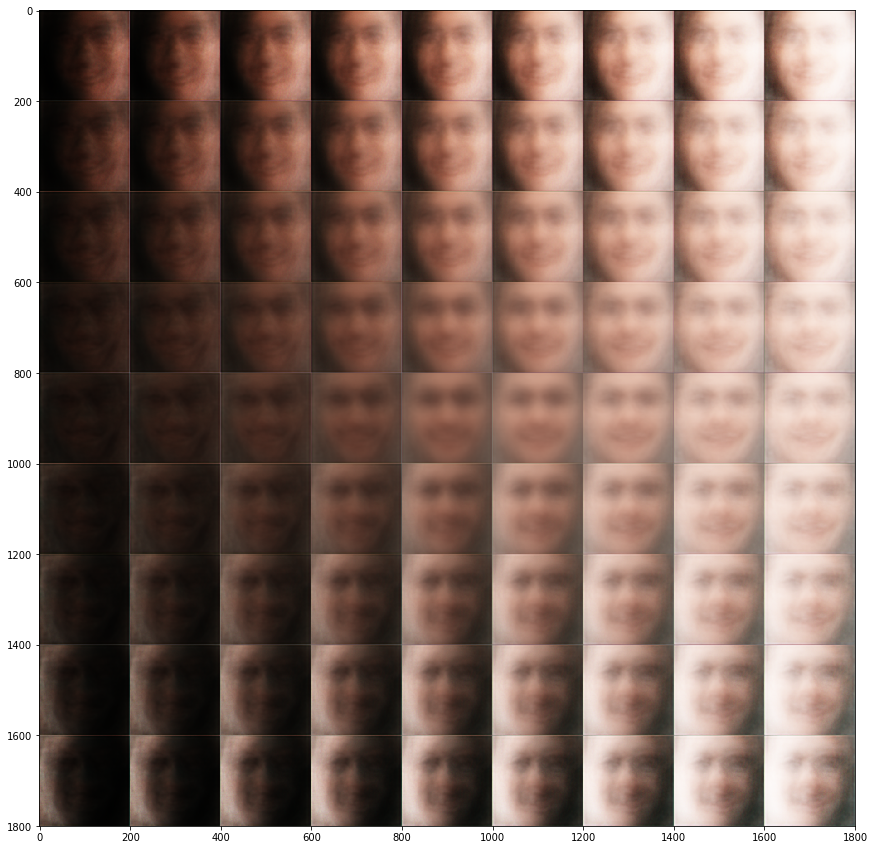

In [26]:
# Declare input
learning_rate = 0.001
n_epochs = 20
batch_size = 64

loss, recon, kl = vae_loss(input_img,decoded)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

img_list_train = img_list 
delete_files('.//outputs//')
#Delete all files in loc
delete_files('.//outputs_latent_space//')

init = tf.global_variables_initializer()

LOSS= list()
output_list = list()
with tf.Session() as sess:
    init.run()
    
    iteration = 0
    for epoch in range(n_epochs):
        
        for batch in mini_batches(data=img_list_train,batch_size=batch_size,shuffle=True):

            sess.run(training_op, feed_dict={input_img:batch})
            loss_ = loss.eval(feed_dict={input_img:batch})
            LOSS.append(loss_)
   
            iteration+=1
            
            dec = decoded.eval(feed_dict={input_img:img_list_train})
            if iteration%5==0:
                cv2.imwrite('./outputs/temp_VAE_{}.png'.format(iteration),
                            img_con(decoded.eval(feed_dict={input_img:img_list_train})[340]))
                               
        print("Epoch:{} Loss:{:0.3f}, Recon:{:0.3f}, kl:{:0.3f}".format(epoch, loss_,
                                            recon.eval(feed_dict={input_img:batch}),
                                            kl.eval(feed_dict={input_img:batch})))
        
    model_output = decoded.eval(feed_dict={input_img:img_list})
    
    # Generate some images using a grid space
    n = 9
    digit_size = 200
    epsilon_std = 5.0

    figure = np.zeros((digit_size * n, digit_size * n,3))
    grid_x = np.linspace(-1.0, 1.0, n)
    grid_y = np.linspace(-1.0, 1.0, n)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]]) * epsilon_std
            gen_img = decoded.eval(feed_dict={z:z_sample})

            digit = gen_img[0]

            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(15, 15))
    plt.imshow(figure)
    plt.savefig('./outputs_latent_space/temp_VAE_{}.png'.format(iteration))

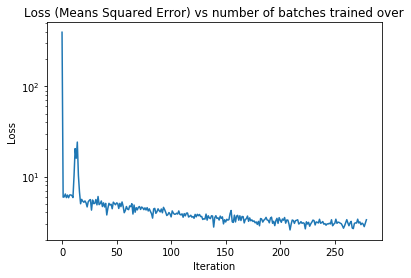

In [27]:
plt.plot(LOSS)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss (Means Squared Error) vs number of batches trained over")
plt.show()

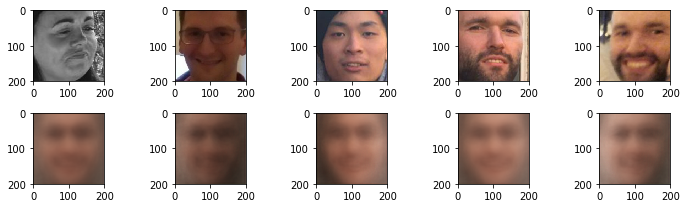

In [62]:
# Plot some of the images to see what's they look like
n=5
m = 14
fig, axes = plt.subplots(2,n,figsize=(2*n,3))

for i in range(n):
    axes[0,i].imshow(img_list[i+m])
    axes[1,i].imshow(model_output[i+m])

fig.tight_layout()
#plt.savefig("outputs.png")
plt.show()

In [63]:
import imageio
import glob
import re

# open up images and put an eopch number in the top corner
for n, filename in enumerate(glob.glob('./outputs/*.png')):
    num = re.findall(r'\d+', filename)[0]
    
    image = cv2.imread(filename)
    texted_image =cv2.putText(img=np.copy(image), text="Iter: {}".format(num), 
                              org=(10,20),fontFace=1, fontScale=1, color=(0,0,0), thickness=1)
    cv2.imwrite('./outputs/temp_VAE_{}.png'.format(num),texted_image)

In [ ]:
with imageio.get_writer('CNN_VAE2.gif', mode='I') as writer:
    filenames = glob.glob('./outputs/*.png')
    my_tuple = sorted(tuple(zip([int(re.findall(r'\d+', x)[0]) for x in filenames],filenames)))
    last = -1
    filenames = [x[1] for x in my_tuple]
    for i,filename in enumerate(filenames):
        frame = 2*(i**1.0)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
#os.system('CNN_VAE2.gif')